# Web Scraping for Indeed.com and Predicting Salaries
In this project, we will practice two major skills: collecting data by scraping a website and then building a binary predictor with Logistic Regression.

We are going to collect salary information on data science jobs in a variety of markets. Then using the location, title and summary of the job we will attempt to predict the salary of the job. For job posting sites, this would be extraordinarily useful. While most listings DO NOT come with salary information (as you will see in this exercise), being able to extrapolate or predict the expected salaries from other listings can help guide negotiations.

Normally, we could use regression for this task; however, we will convert this problem into classification and use Logistic Regression or any other suitable classifier.

- Question: Why would we want this to be a classification problem?
- Answer: While more precision may be better, there is a fair amount of natural variance in job salaries - predicting a range may be useful.
Therefore, the first part of the assignment will be focused on scraping Indeed.com. In the second, we'll focus on using listings with salary information to build a model and predict additional salaries.

### Scraping job listings from Indeed.com
We will be scraping job listings from Indeed.com using BeautifulSoup. Luckily, Indeed.com is a simple text page where we can easily find relevant entries.

First, look at the source of an Indeed.com page: (http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10").

Notice, each job listing is underneath a div tag with a class name of result. We can use BeautifulSoup to extract those.

**Setup a request (using requests) to the URL below. Use BeautifulSoup to parse the page and extract all results (HINT: Look for div tags with class name result)**
The URL here has many query parameters:

- q for the job search
- This is followed by "+20,000" to return results with salaries (or expected salaries >$20,000)
- l for a location
- start for what result number to start on

In [1]:
URL = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10"


In [2]:
#Importing Dependencies
import requests
import bs4
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import csv

#Importing Sci-kit + Stats Models Dependencies
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, cross_val_score

#Models
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB

#GridSearch
from sklearn.model_selection import GridSearchCV

#Pre-processing
from sklearn.preprocessing import StandardScaler

#Scipy Integration for Sparse Matrixes
from scipy import sparse

#Plotting & Visualisation Metrics
from matplotlib import pyplot as plt
import seaborn as sns

#Scoring & Evaluation Metrics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_score, f1_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score


In [3]:
# How to operate a HTTP requests object.

base_url = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10"

req = requests.get(base_url)
soup = BeautifulSoup(req.text, 'html.parser')
results = []

for item in soup.find_all('div', class_='jobsearch-SerpJobCard'):
    results.append(item)

Let's look at one result more closely. A single result looks like
- The salary is available in a nobr element inside of a td element with class='snip'.
- The title of a job is in a link with class set to jobtitle and a data-tn-element='jobTitle'.
- The location is set in a span with class='location'.
- The company is set in a span with class='company'.

In [4]:
def extract_salaries(soup, np=np):
    salaries = []
    for item in soup.find_all('div', class_='jobsearch-SerpJobCard'):
        if item.find('span', class_='salary') is not None:
            try:
                salaries.append(item.find('span', class_='salary').getText().strip().replace('\n', ''))
            except:
                salaries.append(np.nan)
        else:
            pass
    return salaries

In [5]:
def extract_titles(soup, np=np):
    titles = []
    for item in soup.find_all('div', class_='jobsearch-SerpJobCard'):
        if item.find('span', class_='salary') is not None:
            try:
                titles.append(item.find('div', class_='title').getText().strip())
            except:
                titles.append(np.nan)
        else:
            pass
    return titles

In [6]:
def extract_locations(soup, np=np):
    locations = []
    for item in soup.find_all('div', class_='jobsearch-SerpJobCard'):
        if item.find('span', class_='salary') is not None:
            try:
                locations.append(item.find('span', class_='location').getText().replace('\n','').strip())
            except:
                locations.append(np.nan)
        else:
            pass
    return locations

In [7]:
def extract_companies(soup, np=np):
    companies = []
    for item in soup.find_all('div', class_='jobsearch-SerpJobCard'):
        if item.find('span', class_='salary') is not None:
            try:
                companies.append(item.find('span', class_='company').getText().replace('\n','').strip())
            except:
                companies.append(np.nan)
        else:
            pass
    return companies

In [8]:
## 🔥🚀 #Let's scrape the companies ratings (the maximum width is 60px so we can use this as 100%) 🔥🚀

def extract_ratings(soup, np=np):
    import re
    ratings = []
    for item in soup.find_all('div', class_='jobsearch-SerpJobCard'):
        if item.find('span', class_='salary') is not None:
            try:
                width = item.find('span',class_='rating').attrs['style']
                rating = float(findall(':([^p]+)', width)[0])
                ratings.append((round(((rating / 60) * 100))))
            except:
                ratings.append(np.nan)
        else:
            pass
    return ratings


In [9]:
# Let's extract all of the delightful ahref <a> links for the individual job listings.

def extract_links(soup, np=np):
    urls = []
    for item in soup.find_all('div', class_='result'):
        if item.find('span', class_='salary') is not None:
            try:
                urls.append('https://www.indeed.com' + item.find('a').attrs['href'])
            except:
                urls.append(np.nan)
        else:
            pass
    return urls


Now, to scale up our scraping, we need to accumulate more results. We can do this by examining the URL above.

"http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10"
There are two query parameters here we can alter to collect more results, the l=New+York and the start=10. The first controls the location of the results (so we can try a different city). The second controls where in the results to start and gives 10 results (thus, we can keep incrementing by 10 to go further in the list).

**Complete the following code to collect results from multiple cities and starting points.**
- Enter your city below to add it to the search.
- Remember to convert your salary to U.S. Dollars to match the other cities if the currency is different.

In [10]:
from IPython.display import clear_output

In [11]:
YOUR_CITY = 'London'


In [12]:
city_list = ['New+York', 'Chicago', 'San+Francisco', 'Austin', 'Seattle', 
    'Los+Angeles', 'Philadelphia', 'Atlanta', 'Dallas', 'Pittsburgh', 
    'Portland', 'Phoenix', 'Denver', 'Houston', 'Miami', YOUR_CITY]

In [13]:
len(city_list)


16

In [14]:
url_template = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l={}&start={}"
max_results_per_city = 150 # Set this to a high-value (5000) to generate more results. 
# Crawling more results, will also take much longer. First test your code on a small number of results and then expand.

results = {
     'Salaries($)': [],
     'Titles': [],
     'Locations': [],
     'Companies': [],
     'Ratings': [],
     'URL_Listings': []
 }


with open('test.csv', 'a') as f:
    w = csv.writer(f)
    for city in set(['New+York', 'Chicago', 'San+Francisco', 'Austin', 'Seattle', 
        'Los+Angeles', 'Philadelphia', 'Atlanta', 'Dallas', 'Pittsburgh', 
        'Portland', 'Phoenix', 'Denver', 'Houston', 'Miami', YOUR_CITY]):

        page_index = 0

        for start in range(0, max_results_per_city):
            
            clear_output(wait=True)
            # Let's Create An Index For The URL's.
            page_index += 10

            # Let's Make The URL Dynamnic Via Formatting.
            user_agent = {'User-agent': 'Mozilla/5.0'}
            dynamic_url = url_template.format(city, page_index)
            req = requests.get(dynamic_url)
            soup = BeautifulSoup(req.text, 'html.parser')

            # Appending The Results To A Dictionary!
            results['Salaries($)'].extend(extract_salaries(soup))
            results['Titles'].extend(extract_titles(soup))
            results['Locations'].extend(extract_locations(soup))
            results['Companies'].extend(extract_companies(soup))
            results['Ratings'].extend(extract_ratings(soup))
            results['URL_Listings'].extend(extract_links(soup))
            
            
            #This method allows us to save intermediate results for web scraping via a CSV writerows Append.
            data = [list(item) for item in list(zip(extract_salaries(soup),extract_titles(soup)
                                                    ,extract_locations(soup), extract_companies(soup),
                                                    extract_companies(soup), extract_ratings(soup), 
                                                    extract_links(soup)))]
            w.writerows(data)
            print(city, page_index)

Portland 1500



**Use the functions you wrote above to parse out the 4 fields - location, title, company and salary. Create a dataframe from the results with those 4 columns.**

In [15]:
# To avoid Pandas truncating our Listing_URL columns, let's increase the max_colwidth.
pd.set_option("display.max_colwidth", 10000)
df = pd.DataFrame(results, columns = list(results.keys()))

Lastly, we need to clean up salary data.

- Only a small number of the scraped results have salary information - only these will be used for modeling.
- Some of the salaries are not yearly but hourly or weekly, these will not be useful to us for now.
- Some of the entries may be duplicated.
- The salaries are given as text and usually with ranges.

In [16]:
df.head()

,Salaries($),Titles,Locations,Companies,Ratings,URL_Listings
0,"From $70,000 a year",NaN,"Columbus, OH",Smart Health Integrated,NaN,https://www.indeed.com/company/Smart-Health-Integrated/jobs/Machine-Learning-Engineer-dff37119f53a6a95?fccid=ba0a313825c4a492&vjs=3
1,"From $70,000 a year",NaN,"Columbus, OH",Smart Health Integrated,NaN,https://www.indeed.com/company/Smart-Health-Integrated/jobs/Machine-Learning-Engineer-dff37119f53a6a95?fccid=ba0a313825c4a492&vjs=3
2,"From $70,000 a year",NaN,"Columbus, OH",Smart Health Integrated,NaN,https://www.indeed.com/company/Smart-Health-Integrated/jobs/Machine-Learning-Engineer-dff37119f53a6a95?fccid=ba0a313825c4a492&vjs=3
3,"From $70,000 a year",NaN,"Columbus, OH",Smart Health Integrated,NaN,https://www.indeed.com/company/Smart-Health-Integrated/jobs/Machine-Learning-Engineer-dff37119f53a6a95?fccid=ba0a313825c4a492&vjs=3
4,"From $70,000 a year",NaN,"Columbus, OH",Smart Health Integrated,NaN,https://www.indeed.com/company/Smart-Health-Integrated/jobs/Machine-Learning-Engineer-dff37119f53a6a95?fccid=ba0a313825c4a492&vjs=3


**Write a function that takes a salary string and converts it to a number, averaging a salary range if necessary.**

In [18]:
#Solving the string manipulation problem with Regex and an IF statement for months vs years.

def convert_digits(a):
    import re

    #If there is a month in the string.
    digits = []
    if 'month' in a:
        for x in a.split():
                x_ = x.replace(',','')
                x_ = re.sub('[$,£]', '', x_)
                if x_.isdigit():
                    year_figure = (int(x_) * 12)
                    digits.append(year_figure)

        if len(digits) == 1:
            return digits[0]

        else:
            return sum(digits) / len(digits)

    #If there is no month in the string.

    else:
        for x in a.split():
            x_ = x.replace(',','')
            x_ = re.sub('[$,£]', '', x_)
            if x_.isdigit():
                digits.append(int(x_))

        if len(digits) == 1:
            return digits[0]

        else:
            return sum(digits) / len(digits)

In [19]:
### Data Cleaning ### - After scraping data for several days, now we can remove any of the duplicates.

# Let's apply our formula to extract all of the rows.
df['Salaries($)'] = df['Salaries($)'].apply(convert_digits)
df = pd.DataFrame.drop_duplicates(df)
# Let's clean up the locations column.

def locations(a):
    import re
    result = re.sub(r"[0-9]", "", str(a))
    return re.sub(r'\([^)]*\)', '', result)

df['Locations'] = df['Locations'].apply(locations)

**The Code Below Allows Us To Append To Our Existing CSV Data From Multiple Scrapes**

In [29]:
export_csv = df.to_csv('exported_dataframe.csv', index= None, header=True)

# QUESTION 2: Factors that distinguish job category
Using the job postings you scraped for part 1 (or potentially new job postings from a second round of scraping), identify features in the data related to job postings that can distinguish job titles from each other. There are a variety of interesting ways you can frame the target variable, for example:

- What components of a job posting distinguish data scientists from other data jobs?
- What features are important for distinguishing junior vs. senior positions?
- Do the requirements for titles vary significantly with industry (e.g. healthcare vs. government)?

You may end up making multiple classification models to tackle different questions. Be sure to clearly explain your hypotheses and framing, any feature engineering, and what your target variables are. The type of classification model you choose is up to you. Be sure to interpret your results and evaluate your model's performance.

**Load in the the data of scraped salaries**

In [32]:
cleaned_df = pd.read_csv("exported_dataframes.csv")

In [33]:
len(cleaned_df)


544

In [34]:
#Let's Remove Any Salaries That Are Lower Than $15,000

cleaned_df = cleaned_df[cleaned_df['Salaries($)'] > 15000]

**We want to predict a binary variable - whether the salary was low or high. Compute the median salary and create a new binary variable that is true when the salary is high (above the median).**
We could also perform Linear Regression (or any regression) to predict the salary value here. Instead, we are going to convert this into a binary classification problem, by predicting two classes, HIGH vs LOW salary.

While performing regression may be better, performing classification may help remove some of the noise of the extreme salaries. We don't have to choose the median as the splitting point - we could also split on the 75th percentile or any other reasonable breaking point.

In fact, the ideal scenario may be to predict many levels of salaries.

In [35]:
# Calculating The Median.

median = cleaned_df['Salaries($)'].median()
print(median)

101515.5


In [36]:
def salary_class (x, median=median):
    if x > median:
        return 'HIGH SALARY'
    else:
        return 'LOW SALARY'

In [37]:
cleaned_df['Salary_Class'] = cleaned_df['Salaries($)'].apply(salary_class)


**Thought experiment: What is the baseline accuracy for this model?**


In [38]:
## The Baseline Accuracy Will Be The Most Frequent Class Within The Distribution

cleaned_df['Salary_Class'].value_counts()

LOW SALARY     266
HIGH SALARY    265
Name: Salary_Class, dtype: int64

In [39]:
# Therefore Our Baseline Accuracy Is 50.09%.

round((cleaned_df[(cleaned_df['Salary_Class'] == 'LOW SALARY')].shape[0] / cleaned_df.shape[0]) * 100, 2)

50.09

In [40]:
# Let's Remove All Of Entries That Don't Have Ratings

cleaned_df = cleaned_df[cleaned_df['Ratings'].notnull()]

In [41]:
#Feature Engineering 

#1. Creating The States.
cleaned_df['State'] = cleaned_df['Locations'].apply(lambda x: str(x).split()[-1])

#2. Separating Out The Location From State.
cleaned_df['Locations'] = cleaned_df['Locations'].apply(lambda x: (str(" ".join(str(x).split()[:-1])).replace(',','')))

In [42]:
cleaned_df.describe()

,Salaries($),Ratings
count,281.000000,281.000000
mean,99034.782918,80.135231
std,42913.952169,11.368952
min,26832.000000,32.000000
25%,65385.500000,72.000000
50%,98797.000000,85.000000
75%,125000.000000,88.000000
max,500000.000000,100.000000


C:\Anaconda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


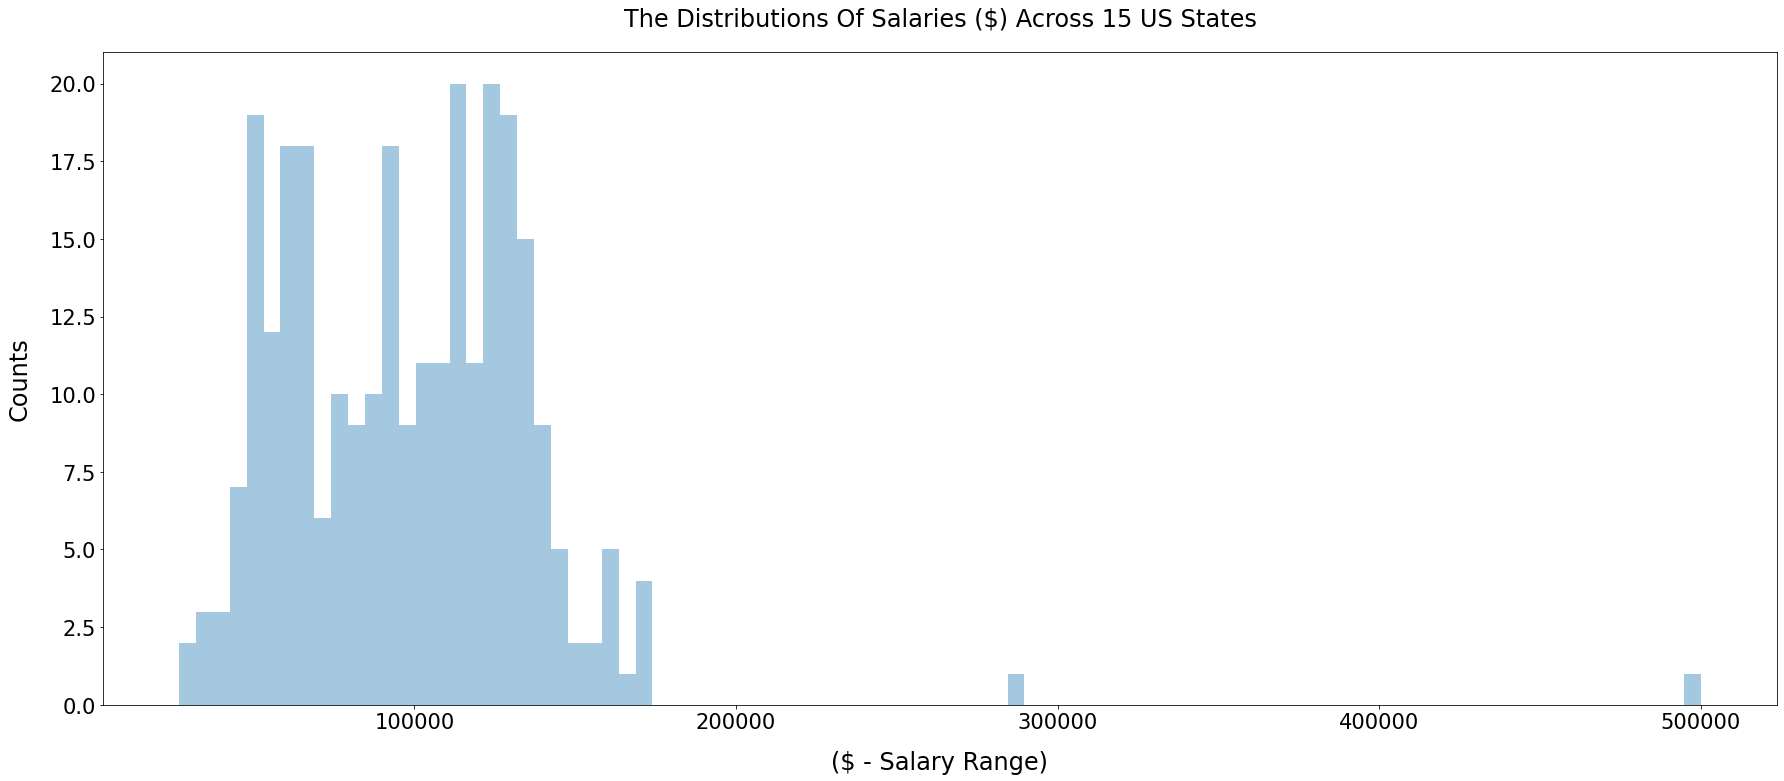

In [43]:
fix , ax = plt.subplots(figsize=(30,12))
sns.distplot(cleaned_df['Salaries($)'], bins = 90, kde=False)
plt.title('The Distributions Of Salaries ($) Across 15 US States', fontsize='24', pad=27)
plt.xlabel('($ - Salary Range)', fontsize='24', labelpad=18)
plt.ylabel('Counts', fontsize='24', labelpad=18)
ax.tick_params(axis='x', which='major', labelsize=21)
ax.tick_params(axis='y', which='major', labelsize=21)
plt.show()

## **Create a classification model to predict High/Low salary.**
**Model based on location:**

- Start by ONLY using the location as a feature.
- Use logistic regression with both statsmodels and sklearn.
- Use a further classifier you find suitable.
- Remember that scaling your features might be necessary.
- Display the coefficients/feature importances and write a short summary of what they mean.

**Model taking into account job levels and categories:**

- Create a few new variables in your dataframe to represent interesting features of a job title.
- For example, create a feature that represents whether 'Senior' is in the title or whether 'Manager' is in the title.
- Incorporate other text features from the title or summary that you believe will predict the salary.
- Then build new classification models including also those features. Do they add any value?
- Tune your models by testing parameter ranges, regularization strengths, etc. Discuss how that affects your models.
- Discuss model coefficients or feature importances as applicable.

**Model evaluation:**


Your boss would rather tell a client incorrectly that they would get a lower salary job than tell a client incorrectly that they would get a high salary job. Adjust one of your models to ease his mind, and explain what it is doing and any tradeoffs.

- Use cross-validation to evaluate your models.
- Evaluate the accuracy, AUC, precision and recall of the models.
- Plot the ROC and precision-recall curves for at least one of your models.

# Model 1 - (Features: Only Locations)

In [44]:
X = cleaned_df.copy()

In [45]:
X = cleaned_df.copy()
X = X.dropna(how='any')
X.drop(columns=['Companies', 'Salaries($)', 'Titles'], inplace=True)
X = pd.get_dummies(data=X, drop_first=True, columns=['State', 'Locations'])
y = X.pop('Salary_Class')

In [46]:
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=1, stratify=y)

In [47]:
models = [KNeighborsClassifier(),
          LogisticRegression(solver='lbfgs', multi_class='auto'),
          DecisionTreeClassifier(),
          SVC(gamma='scale'),
          RandomForestClassifier(n_estimators=100),
          ExtraTreesClassifier(n_estimators=100)]

skf = StratifiedKFold(n_splits=5, shuffle=False)

for model in models:
    print(model)
    model.fit(X_train, y_train)
    print("The Cross Validation Score: ", round(np.mean(cross_val_score(model, X_train, y_train, cv=skf)),2))
    y_pred = model.predict(X_test)
    print('---------')
    
    
models[1].fit(X_train, y_train)
model_1_coefficients_matrix = pd.DataFrame(np.abs(np.reshape(models[1].coef_, (-1, 1))), 
                                           index= X_train.columns, columns=['Log_Odds_Coefficients'])

KNeighborsClassifier()
The Cross Validation Score:  0.69
---------
LogisticRegression()


C:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

The Cross Validation Score:  0.63
---------
DecisionTreeClassifier()
The Cross Validation Score:  0.74
---------
SVC()
The Cross Validation Score:  0.52
---------
RandomForestClassifier()
The Cross Validation Score:  0.75
---------
ExtraTreesClassifier()
The Cross Validation Score:  0.71
---------


C:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Model 1 - Absolute Coefficients

In [48]:
model_1_coefficients_matrix.sort_values(by='Log_Odds_Coefficients', ascending=False).head(12)


,Log_Odds_Coefficients
Locations_Chicago,1.149558
Locations_San Francisco,1.146946
Locations_Berkeley,1.140124
Locations_Manhattan,1.033832
Locations_New York,1.027445
Locations_Phoenix,0.938306
State_GA,0.933725
Locations_Dallas,0.917539
Locations_Denver,0.911106
State_NY,0.888323


The absolute coefficients are largest within the following cities:

- Chicago
- San Francisco
- Berkeley
- Manhattan
- New York
- Phoenix

This means any jobs that are located within these areas will have larger (positive/negative) changes to the log odds and probabilties (class 0 or class 1 assignment) in comparison to the other locations.

Additionally there are 3 states which have large absolute coefficient values: GA, NY and WA.



In [51]:
# #Please Find The Commented Code Below For Running Logistic Regression Using Stats Models

#import statsmodels.discrete.discrete_model as sm
#import statsmodels.formula.api as sm
#import statsmodels as sm
#def binarizer(item):
#     if item == 'HIGH SALARY':
#         return 0
#     else:
#         return 1

#X = cleaned_df.copy()
#X = X.dropna(how='any')
#X.drop(columns=['Companies', 'Salaries($)'], inplace=True)
#X = pd.get_dummies(data=X, drop_first=True, columns=['State', 'Locations', 'Titles'])
#X['intercept'] = 1
#y = X.pop('Salary_Class')
#y = y.apply(binarizer)

#sm_log_reg_model = sm.Logit(y, X).fit(method='lbfgs')
#sm_log_reg_model.summary()


# Model 2 - (Features: Locations + Dummifyed Job Titles)

In [52]:
#Display the coefficients/feature importances and write a short summary of what they mean.

from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold

from warnings import filterwarnings
filterwarnings('ignore')


X = cleaned_df.copy()
X = X.dropna(how='any')
X.drop(columns=['Companies', 'Salaries($)'], inplace=True)
X = pd.get_dummies(data=X, drop_first=True, columns=['State', 'Locations', 'Titles'])
y = X.pop('Salary_Class')

X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=1, stratify=y)


skf = StratifiedKFold(n_splits=5, shuffle=False)

log_reg_model = LogisticRegression(solver='lbfgs', multi_class='auto')
log_reg_model.fit(X_train, y_train)
y_pred = log_reg_model.predict(X_test)

print('--------')
print("The Cross Validation Score", round(np.mean(cross_val_score(log_reg_model, X_train, y_train, 
                                                                                              cv=skf, verbose=0, )),3))
print("The Logistic Regression Accuracy Score", np.round(log_reg_model.score(X_test, y_test),2))
print('--------')

### Producing The Coefficients ###

Logistic_Regression_Coefficients = log_reg_model.coef_

## Reshaping A Numpy Array + Setting Absolute Values For The Coefficients  ##
Logistic_Regression_Coefficients = np.abs(np.reshape(Logistic_Regression_Coefficients, (-1, 1)))


coefficients_matrix = pd.DataFrame(Logistic_Regression_Coefficients, index= X_train.columns, columns=['Log_Odds_Coefficients'])

--------
The Cross Validation Score 0.66
The Logistic Regression Accuracy Score 0.81
--------


# Model 2 - Absolute Coefficients
The coefficients have a linear impact on the log-odds. All of the coefficients (whether positive or negative) below have been converted to an absolute value.

After dummifying the Job Titles, we can see that titles with the exact words "Data Scientist" are the largest Log Odds Coefficients, additionally the locations from the first model are still prevalent within this model.

In [53]:
coefficients_matrix.sort_values(by='Log_Odds_Coefficients', ascending=False).head(12)


,Log_Odds_Coefficients
Titles_Data Scientist,1.325967
Locations_Chicago,1.023918
Locations_Berkeley,0.991466
Locations_Manhattan,0.990899
Locations_New York,0.973044
Locations_San Francisco,0.970968
State_GA,0.865584
Locations_Phoenix,0.847192
State_NY,0.826111
Locations_Dallas,0.802664


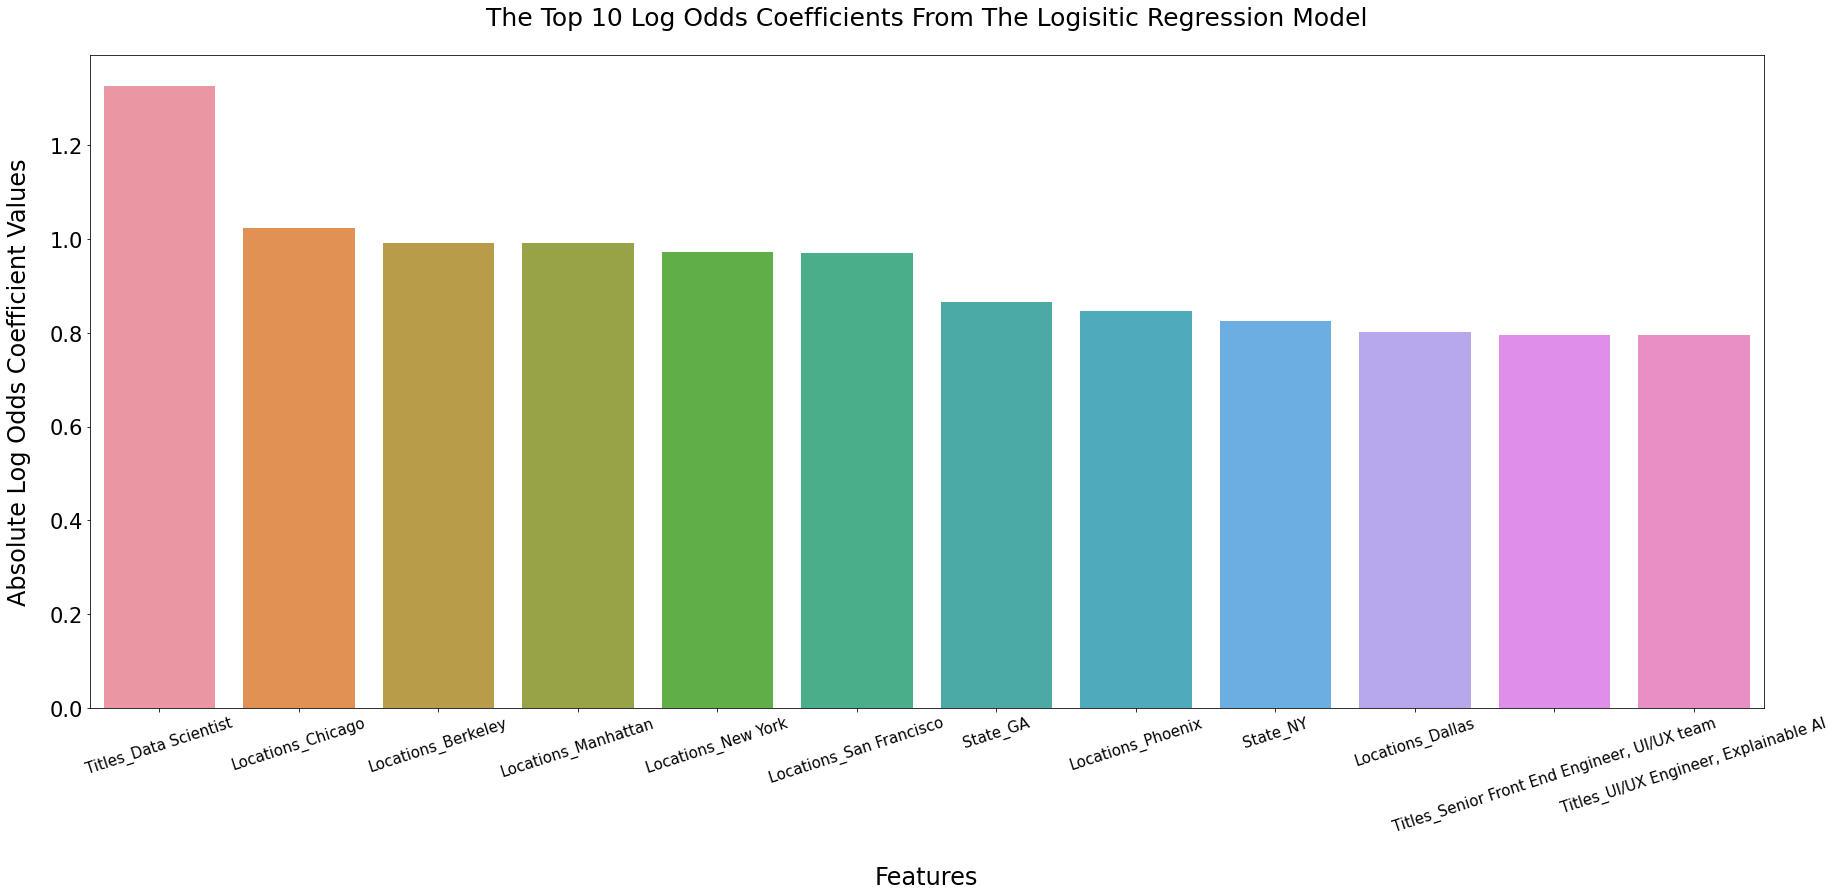

In [54]:

fig, ax = plt.subplots(figsize=(30,12))
sns.barplot(x=coefficients_matrix.sort_values(by='Log_Odds_Coefficients', ascending=False).head(12).index,
            y= [float(item) for item in coefficients_matrix.sort_values(by='Log_Odds_Coefficients', ascending=False).head(12).values])
plt.title('The Top 10 Log Odds Coefficients From The Logisitic Regression Model', pad=30, fontsize='25')
plt.xlabel('Features', fontsize='24', labelpad=30)
plt.ylabel('Absolute Log Odds Coefficient Values', fontsize='24', labelpad=18)
ax.tick_params(axis='x', which='major', labelsize=15, rotation=18)
ax.tick_params(axis='y', which='major', labelsize=21)

# Model 3 - (Features: Locations + TFID Vectorized Job Titles)

In [55]:

#Additional Feature Engineering - NLP Text Data

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words = 'english'
                            ,min_df=3, 
                             ngram_range=(1, 4),
                             max_features = 1000,
                            )

X = cleaned_df.copy()
X = X.dropna(how='any')
X.drop(columns=['Companies', 'Salaries($)'], inplace=True)
X = pd.get_dummies(data=X, drop_first=True, columns=['State', 'Locations'])
y = X.pop('Salary_Class')

In [56]:
X2_train, X2_test, y2_train, y2_test = train_test_split(
X, y, test_size=0.2, random_state=1, stratify=y)

X2_train_titles = vectorizer.fit_transform(X2_train['Titles'])
X2_test_titles = vectorizer.transform(X2_test['Titles'])

X2_train.drop(columns=['Titles'], inplace=True)
X2_test.drop(columns=['Titles'], inplace=True)

X_Train_Sparse = sparse.csr_matrix(X2_train.values)
X_Test_Sparse = sparse.csr_matrix(X2_test.values)

y2_train.reset_index(drop=True)
y2_test.reset_index(drop=True)

X2_train = sparse.hstack((X2_train_titles, X_Train_Sparse))
X2_test = sparse.hstack((X2_test_titles, X_Test_Sparse))

In [57]:
models = [KNeighborsClassifier(),
          LogisticRegression(solver='lbfgs', multi_class='auto'),
          DecisionTreeClassifier(),
          SVC(gamma='scale'),
          RandomForestClassifier(n_estimators=100),
          ExtraTreesClassifier(n_estimators=100)]

for model in models:
    print(model)
    model.fit(X2_train, y2_train)
    score = round(model.score(X2_test, y2_test),2)
    print("The Cross Validation Score: ", round(np.mean(cross_val_score(model, X2_train, y2_train, cv=skf)),2))
    print('Accuracy Score On X_test Data', score)
    print('---------')

KNeighborsClassifier()
The Cross Validation Score:  0.73
Accuracy Score On X_test Data 0.7
---------
LogisticRegression()
The Cross Validation Score:  0.84
Accuracy Score On X_test Data 0.77
---------
DecisionTreeClassifier()
The Cross Validation Score:  0.84
Accuracy Score On X_test Data 0.74
---------
SVC()
The Cross Validation Score:  0.52
Accuracy Score On X_test Data 0.53
---------
RandomForestClassifier()
The Cross Validation Score:  0.86
Accuracy Score On X_test Data 0.75
---------
ExtraTreesClassifier()
The Cross Validation Score:  0.87
Accuracy Score On X_test Data 0.75
---------


# Model 3 - (Scores)
After vectorizing the text data with TFID our Logistic Regression cross validation score has increased from 0.65 to 0.83. , this shows that our TFID logistic regression model is able to generalize more to unseen/fresh data in comparison to simply dummifying the job titles, however due to having a lower accuracy score on test data (0.74 vs 0.81) dummifying might be a better methodology if we are simply looking to correctly predict a larger amount of observations.

Additionally, given more time a count vectorizer model would be advisable!

Furthermore by adding n_grams from 1,4 in size and increasing the mininum document frequency (min_df) to 3, we've been able to increase both scores:

- The Cross Validation Score: 0.83 --> 0.84
- Accuracy Score On X_test Data 0.74 --> 0.77

# Tuning Our Logistic Regression Model With Grid Search

In [58]:
params = {
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear'],
    'C': np.linspace(0.1,12,1000)
}

In [59]:
import numpy as np


In [60]:
log_reg_cv_model = LogisticRegression()


In [61]:
grid_search_model = GridSearchCV(log_reg_cv_model, 
                                 param_grid = params, 
                                 verbose=1, 
                                 n_jobs=-1,  
                                 cv=skf,
                                return_train_score=True)
                                
grid_search_model.fit(X2_train, y2_train)

Fitting 5 folds for each of 2000 candidates, totalling 10000 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([ 0.1       ,  0.11191191,  0.12382382,  0.13573574,  0.14764765,
        0.15955956,  0.17147147,  0.18338338,  0.1952953 ,  0.20720721,
        0.21911912,  0.23103103,  0.24294294,  0.25485485,  0.26676677,
        0.27867868,  0.29059059,  0.3025025 ,  0.31441441,  0.32632633...
       11.71411411, 11.72602603, 11.73793794, 11.74984985, 11.76176176,
       11.77367367, 11.78558559, 11.7974975 , 11.80940941, 11.82132132,
       11.83323323, 11.84514515, 11.85705706, 11.86896897, 11.88088088,
       11.89279279, 11.9047047 , 11.91661662, 11.92852853, 11.94044044,
       11.95235235, 11.96426426, 11.97617618, 11.98808809, 12.        ]),
                         'penalty': ['l2'], 'solver': ['lbfgs', 'liblinear']},
             return_train_score=True, verbose=1)

In [62]:
pd.DataFrame(grid_search_model.cv_results_).sort_values(by='mean_test_score', ascending=False)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,param_solver,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
978,0.097056,0.006164,0.000000,0.000000,5.92492,l2,lbfgs,"{'C': 5.924924924924925, 'penalty': 'l2', 'solver': 'lbfgs'}",0.844444,0.911111,...,0.865657,0.052455,1,0.966480,0.955307,0.972067,0.960894,0.983333,0.967616,0.009642
754,0.104268,0.009706,0.000400,0.000799,4.59079,l2,lbfgs,"{'C': 4.590790790790791, 'penalty': 'l2', 'solver': 'lbfgs'}",0.844444,0.911111,...,0.861212,0.051226,2,0.955307,0.949721,0.960894,0.944134,0.983333,0.958678,0.013535
1796,0.094581,0.010186,0.000400,0.000800,10.7969,l2,lbfgs,"{'C': 10.796896896896898, 'penalty': 'l2', 'solver': 'lbfgs'}",0.844444,0.888889,...,0.861212,0.049260,2,0.977654,0.966480,0.977654,0.960894,0.988889,0.974314,0.009759
912,0.099991,0.007652,0.000000,0.000000,5.53183,l2,lbfgs,"{'C': 5.531831831831832, 'penalty': 'l2', 'solver': 'lbfgs'}",0.844444,0.911111,...,0.861212,0.051226,2,0.960894,0.960894,0.972067,0.949721,0.983333,0.965382,0.011424
818,0.099993,0.007654,0.003125,0.006249,4.97197,l2,lbfgs,"{'C': 4.971971971971972, 'penalty': 'l2', 'solver': 'lbfgs'}",0.844444,0.911111,...,0.861212,0.051226,2,0.960894,0.949721,0.966480,0.949721,0.983333,0.962030,0.012474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,0.120531,0.041970,0.000999,0.000001,0.123824,l2,lbfgs,"{'C': 0.12382382382382383, 'penalty': 'l2', 'solver': 'lbfgs'}",0.777778,0.844444,...,0.798889,0.038554,1994,0.877095,0.843575,0.882682,0.849162,0.883333,0.867169,0.017213
3,0.007596,0.008208,0.001199,0.000399,0.111912,l2,liblinear,"{'C': 0.11191191191191192, 'penalty': 'l2', 'solver': 'liblinear'}",0.755556,0.822222,...,0.790000,0.037251,1997,0.871508,0.843575,0.882682,0.860335,0.894444,0.870509,0.017612
2,0.095945,0.037952,0.001200,0.000400,0.111912,l2,lbfgs,"{'C': 0.11191191191191192, 'penalty': 'l2', 'solver': 'lbfgs'}",0.777778,0.844444,...,0.789899,0.047326,1998,0.877095,0.826816,0.882682,0.849162,0.900000,0.867151,0.025960
1,0.051169,0.033389,0.001399,0.000489,0.1,l2,liblinear,"{'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}",0.733333,0.800000,...,0.781111,0.039063,1999,0.871508,0.837989,0.882682,0.860335,0.894444,0.869392,0.019375


In [63]:
grid_search_model.score(X2_test, y2_test)


0.7368421052631579

In [64]:
grid_search_model.best_score_


0.8656565656565656

In [65]:
cross_val_score(grid_search_model, X2_train, y2_train)


Fitting 5 folds for each of 2000 candidates, totalling 10000 fits
Fitting 5 folds for each of 2000 candidates, totalling 10000 fits
Fitting 5 folds for each of 2000 candidates, totalling 10000 fits
Fitting 5 folds for each of 2000 candidates, totalling 10000 fits
Fitting 5 folds for each of 2000 candidates, totalling 10000 fits


array([0.82222222, 0.88888889, 0.88888889, 0.88888889, 0.77272727])

By applying grid search, we have been able to increase both our cross validation and scores on the held test data:

- The Cross Validation Score: 0.7 --> 0.3
- Accuracy Score On X_test Data 0.67 --> 0.71


# The Confusion Matrix, ROC Curve + Precision/Recall/Threshold Curve

In [66]:
# Confusion Matrix +  Plot A ROC Curve + Precision Recall Curve

from sklearn.metrics import confusion_matrix

log_reg_model = LogisticRegression(solver='lbfgs', multi_class='auto')
log_reg_model.fit(X_train, y_train)
predictions = log_reg_model.predict(X_test)

In [67]:
CM = confusion_matrix(y_test, predictions, labels=['HIGH SALARY', 'LOW SALARY'])
CM

array([[23,  4],
       [ 7, 23]], dtype=int64)

In [68]:
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
(tn, fp, fn, tp)


(23, 4, 7, 23)

In [69]:

confusion_matrix_df = pd.DataFrame(CM, columns=['High_Salary_Class', 'Low_Salary_Class'], 
                                   index=['It Is A High Salary Job','It Is A Low Salary Job'])

confusion_matrix_df

,High_Salary_Class,Low_Salary_Class
It Is A High Salary Job,23,4
It Is A Low Salary Job,7,23


In [70]:

log_reg_model.classes_

array(['HIGH SALARY', 'LOW SALARY'], dtype=object)

In [71]:
new_array = []

for item in predictions:
    if item == 'HIGH SALARY':
        new_array.append(0)
    else:
        new_array.append(1)
        
new_array = np.array(new_array)

In [72]:
new_array



array([0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1])

In [73]:
predictions

array(['HIGH SALARY', 'LOW SALARY', 'LOW SALARY', 'HIGH SALARY',
       'HIGH SALARY', 'LOW SALARY', 'HIGH SALARY', 'HIGH SALARY',
       'LOW SALARY', 'LOW SALARY', 'LOW SALARY', 'LOW SALARY',
       'LOW SALARY', 'HIGH SALARY', 'HIGH SALARY', 'HIGH SALARY',
       'HIGH SALARY', 'HIGH SALARY', 'HIGH SALARY', 'LOW SALARY',
       'LOW SALARY', 'HIGH SALARY', 'LOW SALARY', 'HIGH SALARY',
       'HIGH SALARY', 'HIGH SALARY', 'LOW SALARY', 'LOW SALARY',
       'HIGH SALARY', 'LOW SALARY', 'HIGH SALARY', 'HIGH SALARY',
       'LOW SALARY', 'HIGH SALARY', 'HIGH SALARY', 'LOW SALARY',
       'HIGH SALARY', 'HIGH SALARY', 'HIGH SALARY', 'LOW SALARY',
       'LOW SALARY', 'LOW SALARY', 'HIGH SALARY', 'LOW SALARY',
       'LOW SALARY', 'LOW SALARY', 'HIGH SALARY', 'HIGH SALARY',
       'LOW SALARY', 'LOW SALARY', 'HIGH SALARY', 'HIGH SALARY',
       'LOW SALARY', 'LOW SALARY', 'HIGH SALARY', 'HIGH SALARY',
       'LOW SALARY'], dtype=object)

In [74]:
probabilities = log_reg_model.predict_proba(X_test)
len(probabilities)


57

In [76]:
!pip install scikit-plot

You should consider upgrading via the 'c:\anaconda\python.exe -m pip install --upgrade pip' command.


# Analysis ROC Curve

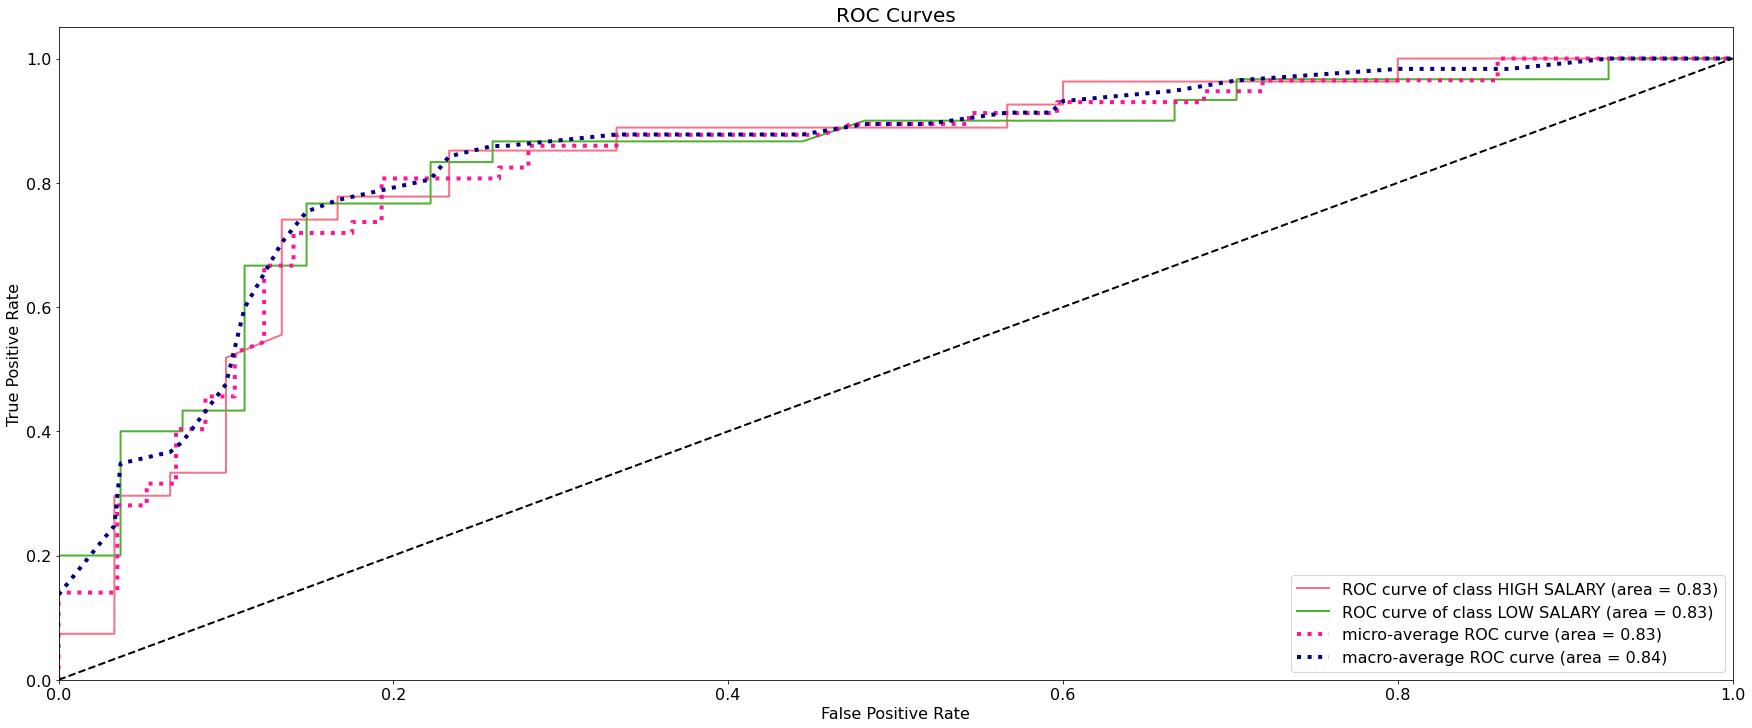

In [77]:
import scikitplot as skplt
from matplotlib.colors import ListedColormap
from sklearn.metrics import classification_report
cmap = ListedColormap(sns.color_palette("husl",3))

skplt.metrics.plot_roc(y_test, probabilities, plot_micro=True, plot_macro=True, 
                       title_fontsize=20, text_fontsize=16, figsize=(30,12), cmap=cmap)
plt.show()

The ROC Curve (receiver operating characteristic curve) has been plotted for both class 0 (High Salary) and class 1 (Low Salary). Firstly we can see that our logistic regression model is outperforming the baseline, this means that as we increase the threshold to remove false positives, we will acquire less false negatives in relation to how many false positives we loose.

The following two equations provide a trade off that we can carefully balance by manually adjusting the threshold:


- True Positive Rate = True Positives / (True Positives + False Negatives)
- False Positive Rate = False Positives / (False Positives + True Negatives)


A true positive rate score of 1.0 would indicate that our classifier would never misidentify one class as another class. Therefore if we would like to optimize the number of true positives in comparison to false negatives, we might choose to adjust the threshold so that we have:

- 0.8 True Positive Rate and 0.2 False Positive Rate.
~Your boss would rather tell a client incorrectly that they would get a lower salary job than tell a client incorrectly that they would get a high salary job.

True Positives = 'LOW SALARY'.
True Negatives = 'HIGH SALARY'.
False Positives = 'Predicted LOW SALARY but actually HIGH SALARY'.
False Negatives = 'Predicted HIGH SALARY but actually LOW SALARY'.
We can therefore opt in to get more False Positives whilst reducing the number of False Negatives. Therefore we will need to reduce the threshold for class 0 which will lead to the following:

- More False Positives (A higher false positive rate).
- Less False Negatives (A higher true positive rate).

# Changing The Threshold
A lower threshold will lead to less false negatives and more false positives. Therefore let's reduce the default threshold for class 0:

In [78]:
Y_probs = pd.DataFrame(log_reg_model.predict_proba(X_test), columns = ['Class_0_pp', 'Class_1_pp'])


In [79]:
Y_probs['pred_class_threshold'] = [1  if x >= 0.78 else 0 for x in Y_probs.Class_1_pp.values ]


In [80]:
def binarizer(item):
    if item == 'HIGH SALARY':
        return 0
    else:
        return 1

y_test = y_test.apply(binarizer)

In [81]:
conmat = np.array(confusion_matrix(
        y_test, Y_probs.pred_class_threshold))

In [82]:

confusion_matrix_df_two = pd.DataFrame(conmat, columns=['High_Salary_Class', 'Low_Salary_Class'], 
                                   index=['It Is A High Salary Job','It Is A Low Salary Job'])

In [83]:
confusion_matrix_df_two


,High_Salary_Class,Low_Salary_Class
It Is A High Salary Job,27,0
It Is A Low Salary Job,24,6


# Precision/Recall/Threshold Curve

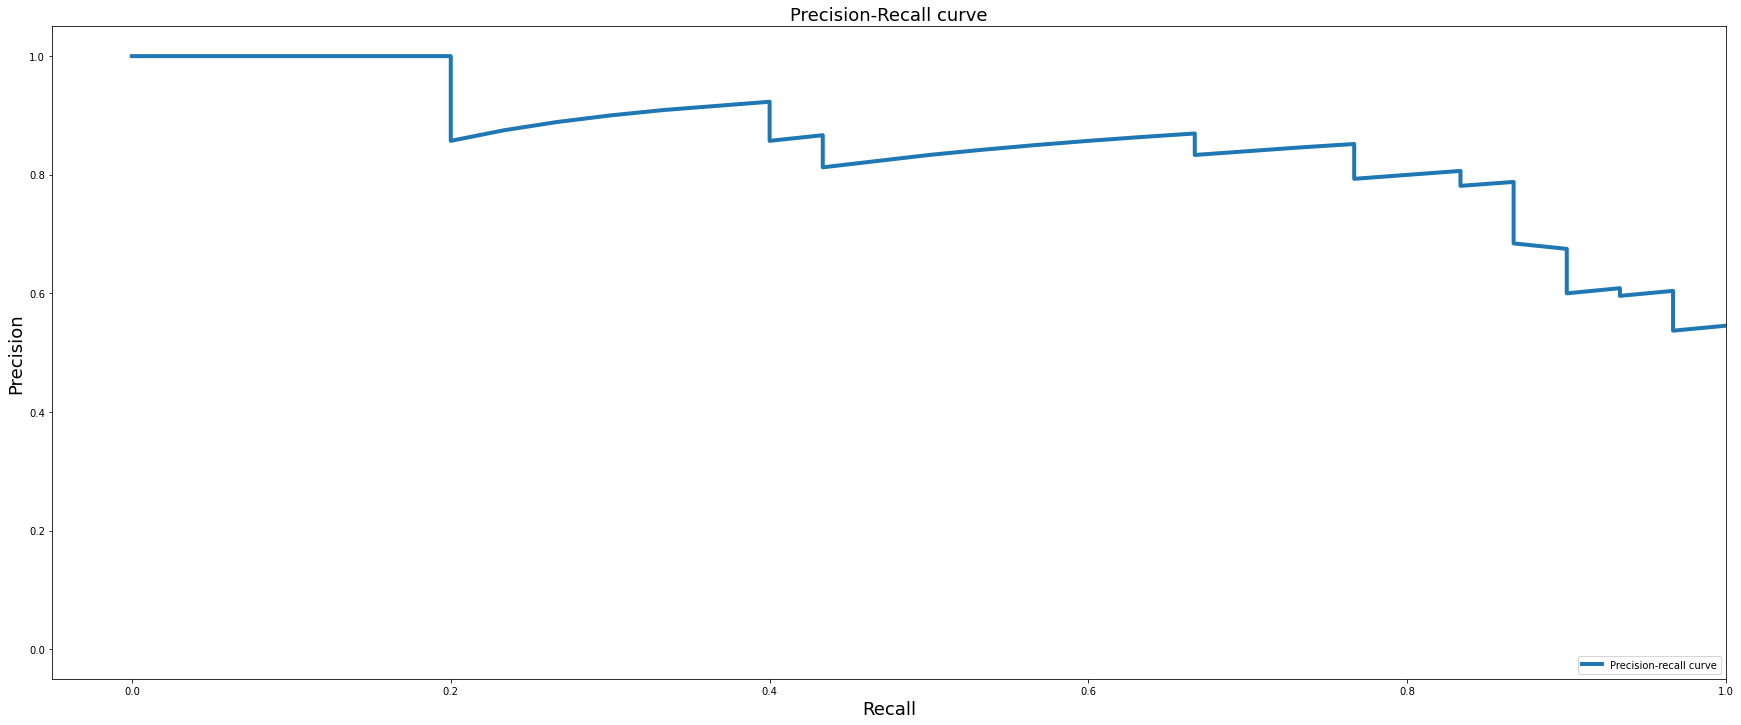

In [84]:
# For class 1, find the area under the curve
precision, recall, threshold = precision_recall_curve(y_test, log_reg_model.predict_proba(X_test)[:,1])

# Plot of a precision-recall curve for class 1 (benign)
plt.figure(figsize=(30,12))
plt.plot(recall, precision, label='Precision-recall curve', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall', fontsize=18)
plt.ylabel('Precision', fontsize=18)
plt.title('Precision-Recall curve', fontsize=18)
plt.legend(loc="lower right")
plt.show()

- Precision = True Positives / (True Positives + False Positives)
A high precision means that there are more true positives in relation to the number of false positives.

- Recall = True Positives / (True Positives + False Negatives)
A high recall means that there are more true positives in relation to the number of false negatives.

Therefore with a recall of 1.0, we will have no false negatives, which would give us a precision of ~0.6. This means the amount of true positives within the total observations would be 60%.

# Summary
After scraping job listings from Indeed.com, cleaning and applying feature engineering (adding additional features) to the data we created a classification model that allows us to predict whether a new job listing will be either a low or high salary.

Logistic regression was our most successful algorithim and had the highest generalizability (ability to make stable predictions to fresh/new data).

The baseline to beat was 50%, we achieved a 75% accuracy score with Logistic Regression.

## Approach
## Data Collection
Using a custom built web scraper, we were able to scrape ~544 raw results from the following States within the US market:

- New York
- Chicago
- San Francisco
- Austin
- Seattle
- Los Angeles
- Philadelphia
- Atlanta
- Dallas
- Pittsburgh
- Portland
- Phoenix
- Denver
- Houston
- Miami
- Data Cleaning

The data was cleaned by removing duplicates/any companies without ratings, salary information was extracted from every listing. Salaries under 15,000 were excluded as there were several observations which had $5000 that could have negatively influenced our model if these observations had been part of the training data.

## Creating A Target Variable
After extracting the salary information, we decided to change the problem which would normally be solved via regression (i.e. predict the salary price) into a binary classification problem.

A binary classification problem is where we have two classes and we are attempting to predict whether a specific observation should be class 0 or class 1.

In order to achieve this we created an additional feature:

HIGH SALARY when the salary was larger than the salary mean.
LOW SALARY when the salary was lower than the salary mean.
## Creating Our Baseline Accuracy Score
In binary classifcation we always take the largest class as our baseline.

(266 / 531 ) * 100 = 50.09%

Therefore if we were to just take our best guess, our baseline to beat is 50.09%.

## Model Building 
Model 1 - Location
Our first model only used the location features which included the State and City. We trialled several different models including:

- KNeighbors
- Logistic Regression
- Decision Trees
- SVC
- Random Forests
- Extra Trees
## Model 2 - Locations + Dummifyed Job Titles

For the second round of modelling we decided to create dummy variables based upon the job description for every listing. This means that the exact title is now included as a predictor feature for our models.

Additionally we decided to only progress with logistic regression as it had the highest accuracy score from our first model.

Accuracy Score can be defined as: True Positives, False Negatives / All Observations
## Model 3 - (Features: Locations + TFID Vectorized Job Titles)

As well as including the previous features, for the third model instead of simply dummifying the job titles we decided to applied natural language processing to the job titles. This means that all words were scaled in reference to how frequent or infrequent they appear throughout all of the job title data. Our third model yielded the highest cross validated score of 0.83.

## Risks
- Not all of the jobs have salary information so by making predictions about the class of a job, we currently are unable able to consider these listings. Therefore we run the risk of training our machine learning model on a select sample of jobs.
Perhaps looking at only companies with ratings isn’t represenative and given more time it might be worthwhile running a separate model without ratings.
- Certain listings contained salary information in the form (similar jobs have salaries between $50,000 - $70,000). This information might not be truly representative and could add skewness into the sampled data.
- Despite the number of classes being low (which would generally yield a lower amount of error in comparison to having 3 - 4 classes) the classes for salary were created from the median but perhaps this is not the most accurate way to define a ‘high salary’ from a ‘low salary’. If we had more time, we could trial the using the 75% quartiles or using several standard deviations above and below the mean.
##Limitations

The current limitations within are model are the following:

Only 15 US states were scraped, however it we wanted to make any inferences about the US job market or other states we would need to gather more data.
The feature’s gathered could be improved with stemming (this involves combining words with a similar intent by converting words to their similar root word).
The data was gathered within a 1 week window which might not be represensativie sample of the true population, therefore it would be worthwhile to scrape for several weeks/months and to see if the same states / locations would still yield a similar influence on our Logistic Regression model.
## Results
Logistic Regression proved to be our best model, with a cross validation score of 0.83 (via Grid Search).

Furthermore the confusion matrix shows us that on test data we achieved:

- True Positives = 'LOW SALARY'.
- True Negatives = 'HIGH SALARY'.
- False Positives = 'Predicted LOW SALARY but actually HIGH SALARY'.
- False Negatives = 'Predicted HIGH SALARY but actually LOW SALARY'.
Without manually adjusting the threshold of 0.5 (50% or larger the prediction will be class 1) we can see that our model has less false positives than false negatives.

Adjusting the probability threshold to have 0 false negatives is possible however this comes with the trade off having a larger amount of false positives.

## Next Steps
The next steps include:

- Testing grid search with different scoring methods (precision, recall).
- Calculate the exact threshold required to reach 0 false negatives with the lowest number of false positives.
- Testing ensemble methods:
- Bagging with Logistic Regression (running multiple logistic regression models on slightly different bootstrapped sample data and then combining their results in the form of a majority vote).
